In [134]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

from torch import nn

from sklearn.metrics import mean_squared_error
from hython.preprocess import reshape, apply_normalization
from hython.datasets.datasets import LSTMDataset
from hython.train_val import train_val
from hython.sampler import RegularIntervalSampler, SpaceSampler
from hython.metrics import mse_metric

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset

from hython.utils import missing_location_idx, reconstruct_from_missing, load
from hython.models.lstm import CustomLSTM

# viz
import matplotlib.pyplot as plt
from hython.viz import plot_sampler
from hython.utils import predict, prepare_for_plotting
from hython.viz import map_bias, map_pbias, map_pearson, map_at_timesteps, ts_compare, plot_sampler

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(43)

# Settings

In [60]:
dynamic_names = ["precip", "pet", "temp"]
static_names = [ 'M', 'thetaS', 'RootingDepth', 'Kext', 'Sl', 'Swood', 'TT', 'KsatHorFrac'] 
target_names = [ "vwc","actevap" ] # "q_river"]

wflow_model = "datademo" # "alps1km_eobs" # "alps1km_cerra", 

fn_forcings =  "forcings.nc" # 'inmaps_eobs_eobsd_makkink_86400_2015_2019.nc' # "forcings.nc"
fn_params = "staticmaps.nc"
fn_targets = "output.nc"

wd = Path("../data") / wflow_model
fp_dynamic_forcings = wd / fn_forcings 
fp_wflow_static_params = wd / fn_params
fp_target = wd / fn_targets


In [61]:
forcings = xr.open_dataset(fp_dynamic_forcings)
params = xr.open_dataset(fp_wflow_static_params)
targets = xr.open_dataset(fp_target).isel(lat=slice(None, None, -1))

In [62]:
# select forcings, wflow parameters and targets
forcings = forcings[dynamic_names]
params = params[static_names]
targets = targets[target_names] 

In [63]:
forcings   

<xarray.Dataset>
Dimensions:      (time: 2192, latitude: 44, longitude: 33)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2020-12-31
  * longitude    (longitude) float64 11.2 11.21 11.22 11.23 ... 11.48 11.49 11.5
  * latitude     (latitude) float64 46.6 46.59 46.58 46.57 ... 46.22 46.21 46.2
    spatial_ref  int64 ...
Data variables:
    precip       (time, latitude, longitude) float32 ...
    pet          (time, latitude, longitude) float32 ...
    temp         (time, latitude, longitude) float32 ...
Attributes: (12/31)
    GRIB_jDirectionIncrementInDegrees:        0.067125
    GRIB_longitudeOfFirstGridPointInDegrees:  5.084033
    GRIB_paramId:                             228228
    long_name:                                total precipitation
    GRIB_stepUnits:                           1
    GRIB_gridDefinitionDescription:           Latitude/longitude
    ...                                       ...
    GRIB_jPointsAreConsecutive:               0
    GRIB_shortName:                           tp
    GRIB_units:                               kg m**-2
    GRIB_dataType:                            forecast
    unit:                                     mm
    precip_fn:                                cerra_daily

In [64]:
try:
    forcings = forcings.rename({"latitude":"lat", "longitude":"lon"})
    params = params.rename({"latitude":"lat", "longitude":"lon"})
except:
    pass

# Hyper parameters

In [65]:
# training 

spatial_batch_size = 32
temporal_sampling_size = 100 
seq_length = 30 # days

# model 

hidden_size = 32

model_params={
    "input_size": 3, #number of dynamic predictors - user_input
    "hidden_size": hidden_size, # user_input
    "output_size": len(target_names), # number_target - user_input
    "number_static_predictors": len(static_names), #number of static parameters - user_input 

}

## The used device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Preprocess

In [66]:
remove_lakes = True

if remove_lakes:
    mask_lakes = (targets.mean(dim = "time")["actevap"] == 0).astype(np.bool_)
    targets = targets.where(~mask_lakes, np.nan)
    forcings = forcings.where(~mask_lakes, np.nan)
    params = params.where(~mask_lakes, np.nan)


timeslice = slice("2016-01-01","2020-12-31")

if timeslice:
    forcings = forcings.sel(time=timeslice)
    targets = targets.sel(time=timeslice)

In [67]:
# UNCOMMENT IF NOT LOADING PREPROCESSED INPUTS

#reshape for training

Xd, Xs, Y  = reshape(
                   forcings, 
                   params, 
                   targets
                   )

#Define the 2D missing values mask. Sampling 

missing_mask = np.isnan(params.M).values

# UNCOMMENT TO SAVE
# np.savez_compressed( surrogate_input_path / f"{wflow_model}", Xd=Xd, Xs=Xs, Y=Y, missing_mask = missing_mask)

dynamic:  (1452, 1827, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (1452, 8)  => (GRIDCELL, FEATURE)
target:  (1452, 1827, 2)  => (GRIDCELL, TIME, TARGET)


In [68]:
# # loading preprocessed data
# Xd, Xs, Y, missing_mask = load(surrogate_input_path, wflow_model, files = ["Xd", "Xs", "Y", "missing_mask"])
# Xd.shape, Xs.shape, Y.shape, missing_mask.shape

In [69]:
# Define the spatial samplers for both training and validation sets. Remeber they should not overlap.

intervals = (2, 2) # every n km
train_origin = (0, 0)
val_origin = (1, 1)

spatial_train_sampler = RegularIntervalSampler(intervals = intervals, origin = train_origin)
spatial_val_sampler = RegularIntervalSampler(intervals = intervals, origin = val_origin) 

In [70]:
# Apply the samplers to the 2D domain. The samplers return the cell indices that can be used later in training and validation.
data2d  = forcings.to_dataarray().transpose("lat","lon", "time", "variable")

sampler_train_meta = spatial_train_sampler.sampling_idx(data2d, missing_mask)
sampler_val_meta = spatial_val_sampler.sampling_idx(data2d, missing_mask)

In [71]:
sampler_train_meta

SamplerResult(
 - id_grid_2d: (44, 33) 
 - idx_sampled_1d: (374,) 
 - idx_sampled_1d_nomissing: (374,)) 
 - idx_missing_1d: (0,) 
 - sampled_grid_dims: (22, 17, 1827, 3)

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'spatial_ref = 0'}, xlabel='longitude coordinate\n[degrees_east]', ylabel='latitude coordinate\n[degrees_north]'>)

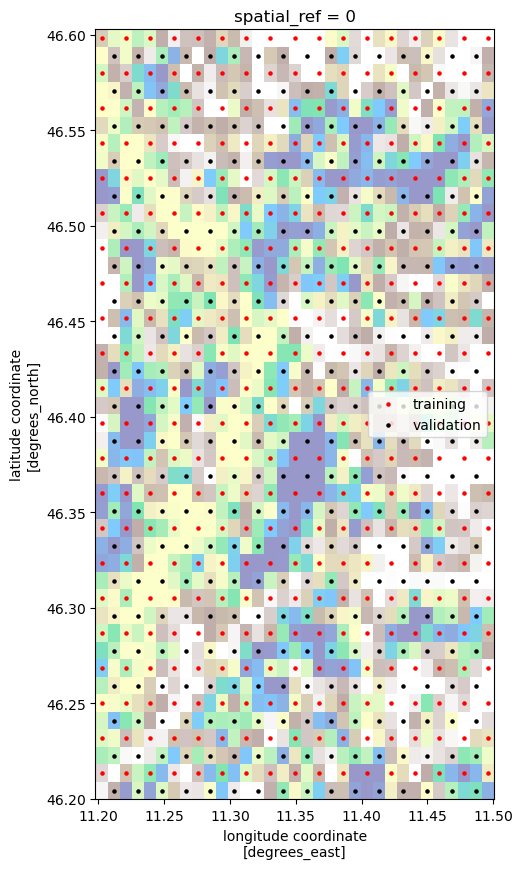

In [72]:
plot_sampler(params.Kext, sampler_train_meta, sampler_val_meta, figsize= (10, 10 ), markersize = 5)

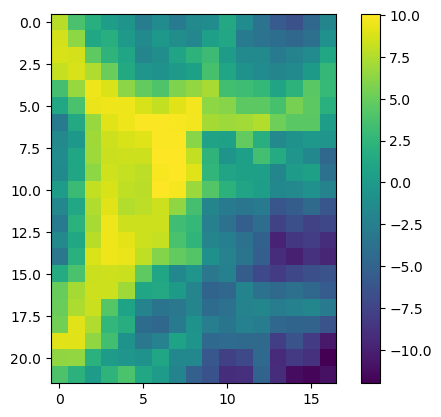

In [73]:
# plt.imshow(Xd[sampler_train_meta.idx_sampled_1d_nomissing].reshape(sampler_train_meta.sampled_grid_dims)[:,:,100,0])
# plt.colorbar()
#plt.imshow(Xd[sampler_train_meta.idx_sampled_1d_nomissing].reshape(sampler_train_meta.sampled_grid_dims)[:,:,100,1])
#plt.colorbar()
plt.imshow(Xd[sampler_train_meta.idx_sampled_1d_nomissing].reshape(sampler_train_meta.sampled_grid_dims)[:,:,100,2])
plt.colorbar()

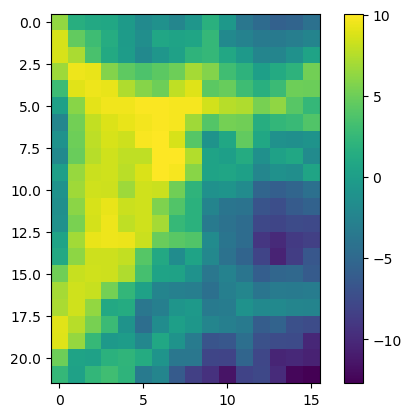

In [74]:
plt.imshow(Xd[sampler_val_meta.idx_sampled_1d_nomissing].reshape(sampler_val_meta.sampled_grid_dims)[:,:,100,2])
plt.colorbar()

In [ ]:
# ## Normalizing v1
# # training
#Xd[sampler_train_meta.idx_sampled_1d_nomissing], d_m, d_std = apply_normalization(Xd[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')
#Xs[sampler_train_meta.idx_sampled_1d_nomissing], s_m, s_std = apply_normalization(Xs[sampler_train_meta.idx_sampled_1d_nomissing], type = "space", how ='standard')
#Y[sampler_train_meta.idx_sampled_1d_nomissing], y_m, y_std = apply_normalization(Y[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')
# # validation 
# Xd[sampler_val_meta.idx_sampled_1d_nomissing] = apply_normalization(Xd[sampler_val_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard', m1 = d_m, m2 = d_std)
# Xs[sampler_val_meta.idx_sampled_1d_nomissing] = apply_normalization(Xs[sampler_val_meta.idx_sampled_1d_nomissing], type = "space", how ='standard', m1 = s_m, m2 = s_std)
# Y[sampler_val_meta.idx_sampled_1d_nomissing] = apply_normalization(Y[sampler_val_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard', m1 = y_m, m2 = y_std)


# # Normalizing v2
# # training
_, d_m, d_std = apply_normalization(Xd[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')
_, s_m, s_std = apply_normalization(Xs[sampler_train_meta.idx_sampled_1d_nomissing], type = "space", how ='standard')
_, y_m, y_std = apply_normalization(Y[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')

d_m, s_m, y_m, d_std, s_std, y_std
# # validation 
# Xd_valid = apply_normalization(Xd[sampler_val_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard', m1 = d_m, m2 = d_std)
# Xs_valid = apply_normalization(Xs[sampler_val_meta.idx_sampled_1d_nomissing], type = "space", how ='standard', m1 = s_m, m2 = s_std)
# Y_valid = apply_normalization(Y[sampler_val_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard', m1 = y_m, m2 = y_std)

In [19]:
Xd = apply_normalization(Xd, type="spacetime", how="standard", m1 = d_m, m2 = d_std)
Xs = apply_normalization(Xs, type="space", how="standard",  m1 = s_m, m2 = s_std)
Y = apply_normalization(Y, type="spacetime",how="standard", m1 = y_m, m2 = y_std)

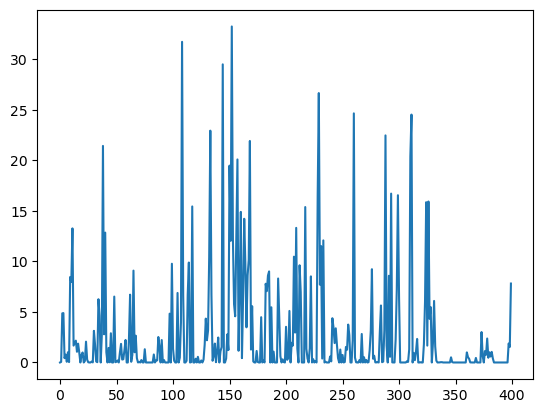

In [18]:
plt.plot(Xd[11,:400,0])

In [75]:
np.isnan(Xd[sampler_val_meta.idx_sampled_1d_nomissing]).any(), np.isnan(Xs[sampler_val_meta.idx_sampled_1d_nomissing]).any(), np.isnan(Y[sampler_val_meta.idx_sampled_1d_nomissing]).any()

(False, False, False)

In [76]:
np.isnan(Xd[sampler_train_meta.idx_sampled_1d_nomissing]).any(), np.isnan(Xs[sampler_train_meta.idx_sampled_1d_nomissing]).any(), np.isnan(Y[sampler_train_meta.idx_sampled_1d_nomissing]).any()

(False, False, False)

# Prepare Model inputs

In [77]:
Xs = torch.Tensor(Xs)
Xd = torch.Tensor(Xd)
Y = torch.Tensor(Y)

Xs.shape, Xd.shape, Y.shape

(torch.Size([1452, 8]),
 torch.Size([1452, 1827, 3]),
 torch.Size([1452, 1827, 2]))

In [78]:
# init datasets
dataset = LSTMDataset(Xd, Y, Xs)

In [79]:
train_sampler = SpaceSampler(dataset, num_samples=100, sampling_indices = sampler_train_meta.idx_sampled_1d_nomissing.tolist())
valid_sampler = SpaceSampler(dataset, num_samples=100, sampling_indices = sampler_val_meta.idx_sampled_1d_nomissing.tolist())

In [80]:
train_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = train_sampler) # implement shuffling in the sampler!
val_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = valid_sampler)

In [125]:
i = 0
for x,y,s in train_loader:
    print(x.shape, y.shape, s.shape)
    #plt.plot(x[...,0].numpy())
    print(i)
    i += 1

torch.Size([32, 1827, 3]) torch.Size([32, 8]) torch.Size([32, 1827, 2])
0
torch.Size([32, 1827, 3]) torch.Size([32, 8]) torch.Size([32, 1827, 2])
1
torch.Size([32, 1827, 3]) torch.Size([32, 8]) torch.Size([32, 1827, 2])
2
torch.Size([32, 1827, 3]) torch.Size([32, 8]) torch.Size([32, 1827, 2])
3
torch.Size([32, 1827, 3]) torch.Size([32, 8]) torch.Size([32, 1827, 2])
4
torch.Size([32, 1827, 3]) torch.Size([32, 8]) torch.Size([32, 1827, 2])
5
torch.Size([32, 1827, 3]) torch.Size([32, 8]) torch.Size([32, 1827, 2])
6
torch.Size([32, 1827, 3]) torch.Size([32, 8]) torch.Size([32, 1827, 2])
7
torch.Size([32, 1827, 3]) torch.Size([32, 8]) torch.Size([32, 1827, 2])
8
torch.Size([32, 1827, 3]) torch.Size([32, 8]) torch.Size([32, 1827, 2])
9
torch.Size([32, 1827, 3]) torch.Size([32, 8]) torch.Size([32, 1827, 2])
10
torch.Size([22, 1827, 3]) torch.Size([22, 8]) torch.Size([22, 1827, 2])
11


In [126]:
len(train_loader.dataset)

1452

# Initialize Model

In [136]:
model = CustomLSTM(model_params)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=11, out_features=32, bias=True)
  (lstm): LSTM(32, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)

# Train/valid settings

In [137]:
path2models= "./checkpoints" 
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
opt = optim.Adam(model.parameters(), lr=1e-2)


loss_fn = nn.MSELoss()

## Set the metric function - here using the same loss function 
metric_fn = mse_metric

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10)

epochs = 30


## Set the training parameters
params_train={
    "num_epochs": epochs,
    "temporal_sampling_idx_change_with_epoch": True,
    "temporal_sampling_size": temporal_sampling_size,
    "seq_length": seq_length,
    "ts_range": Y.shape[1],
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt",
    "device":device,
    "target_names": target_names

}

# Run Train/valid

In [138]:
model, sm_loss_history, sm_metric_history = train_val(model, params_train, plot= False)

Epoch 0/29, current lr=0.01
> /home/iferrario/dev/hython/hython/models/lstm.py(36)forward()
     34         import pdb;pdb.set_trace()
     35 
---> 36         l1 = self.fc0(x_ds)
     37 
     38         lstm_output, _ = self.lstm(l1)



ipdb>  x_ds.shape


torch.Size([32, 30, 11])


ipdb>  n


> /home/iferrario/dev/hython/hython/models/lstm.py(38)forward()
     36         l1 = self.fc0(x_ds)
     37 
---> 38         lstm_output, _ = self.lstm(l1)
     39 
     40         out =  self.fc2(torch.relu(self.fc1(lstm_output)))



ipdb>  l1


tensor([[[ -79.8879,    7.2997,   57.4775,  ...,   27.2276,  122.3092,
           -26.4536],
         [ -80.1719,    3.3316,   55.3897,  ...,   23.4349,  118.9036,
           -26.7182],
         [ -80.6119,    7.2907,   58.1361,  ...,   26.8350,  122.9853,
           -26.3222],
         ...,
         [ -80.5648,    7.3132,   58.1386,  ...,   27.0198,  122.7380,
           -26.4286],
         [ -81.0318,    7.2475,   58.5199,  ...,   26.6770,  123.1742,
           -26.3239],
         [ -80.3452,    7.1335,   57.8231,  ...,   26.9379,  122.4180,
           -26.4589]],

        [[ -86.6048,    9.0859,   73.4061,  ...,   27.1441,  137.4040,
           -39.9260],
         [ -86.8877,    5.1174,   71.3158,  ...,   23.3465,  134.0052,
           -40.1872],
         [ -87.3307,    9.0770,   74.0670,  ...,   26.7531,  138.0779,
           -39.7962],
         ...,
         [ -87.2769,    9.0987,   74.0600,  ...,   26.9279,  137.8443,
           -39.8946],
         [ -87.7432,    9.0334,   74.441

ipdb>  l1.shape


torch.Size([32, 30, 32])


ipdb>  x_ds.shape


torch.Size([32, 30, 11])


ipdb>  self.lstm(l1)


(tensor([[[ 3.9673e-35,  7.6159e-01,  2.1619e-33,  ..., -7.6088e-01,
          -1.2641e-37,  6.2896e-08],
         [ 3.9458e-35,  9.6403e-01,  1.8254e-32,  ..., -9.3989e-01,
          -1.6243e-38,  2.9622e-07],
         [ 3.7154e-35,  9.9505e-01,  3.2222e-33,  ..., -9.9416e-01,
          -1.7828e-37,  3.4952e-08],
         ...,
         [ 3.8930e-35,  1.0000e+00,  3.0371e-33,  ..., -9.9910e-01,
          -6.4033e-36,  4.3226e-08],
         [ 3.9184e-35,  1.0000e+00,  3.1232e-33,  ..., -9.9924e-01,
          -6.1386e-36,  3.0962e-08],
         [ 3.7658e-35,  1.0000e+00,  3.2934e-33,  ..., -9.9886e-01,
          -5.9520e-36,  5.2273e-08]],

        [[ 0.0000e+00,  7.6159e-01,  1.1869e-42,  ..., -7.6159e-01,
          -0.0000e+00,  1.3548e-08],
         [ 0.0000e+00,  9.6401e-01,  8.7063e-42,  ..., -9.6383e-01,
          -0.0000e+00,  6.0701e-08],
         [ 0.0000e+00,  9.9505e-01,  1.5610e-42,  ..., -9.9505e-01,
          -0.0000e+00,  7.3478e-09],
         ...,
         [ 0.0000e+00,  

ipdb>  l, _ = self.lstm(l1)


*** Error in argument: ', _ = self.lstm(l1)'


ipdb>  l = self.lstm(l1)[0]


*** Error in argument: '= self.lstm(l1)[0]'


ipdb>  dd = self.lstm(l1)[0]
ipdb>  dd


tensor([[[ 3.9673e-35,  7.6159e-01,  2.1619e-33,  ..., -7.6088e-01,
          -1.2641e-37,  6.2896e-08],
         [ 3.9458e-35,  9.6403e-01,  1.8254e-32,  ..., -9.3989e-01,
          -1.6243e-38,  2.9622e-07],
         [ 3.7154e-35,  9.9505e-01,  3.2222e-33,  ..., -9.9416e-01,
          -1.7828e-37,  3.4952e-08],
         ...,
         [ 3.8930e-35,  1.0000e+00,  3.0371e-33,  ..., -9.9910e-01,
          -6.4033e-36,  4.3226e-08],
         [ 3.9184e-35,  1.0000e+00,  3.1232e-33,  ..., -9.9924e-01,
          -6.1386e-36,  3.0962e-08],
         [ 3.7658e-35,  1.0000e+00,  3.2934e-33,  ..., -9.9886e-01,
          -5.9520e-36,  5.2273e-08]],

        [[ 0.0000e+00,  7.6159e-01,  1.1869e-42,  ..., -7.6159e-01,
          -0.0000e+00,  1.3548e-08],
         [ 0.0000e+00,  9.6401e-01,  8.7063e-42,  ..., -9.6383e-01,
          -0.0000e+00,  6.0701e-08],
         [ 0.0000e+00,  9.9505e-01,  1.5610e-42,  ..., -9.9505e-01,
          -0.0000e+00,  7.3478e-09],
         ...,
         [ 0.0000e+00,  1

ipdb>  dd.shape


torch.Size([32, 30, 32])


ipdb>  dd[1]


tensor([[ 0.0000e+00,  7.6159e-01,  1.1869e-42,  1.6545e-07, -3.3347e-11,
          0.0000e+00,  9.7416e-31,  7.5933e-01,  2.5893e-11,  7.6159e-01,
         -1.3000e-36, -1.9505e-13, -3.6859e-12, -1.0914e-19, -7.6159e-01,
          7.6159e-01, -1.2989e-40, -4.8934e-01, -6.4884e-30, -7.6159e-01,
          2.8193e-10, -7.2833e-27,  6.9531e-31, -1.0934e-06, -1.4262e-16,
          1.3243e-08, -3.5369e-29,  7.6159e-01,  7.1573e-08, -7.6159e-01,
         -0.0000e+00,  1.3548e-08],
        [ 0.0000e+00,  9.6401e-01,  8.7063e-42,  9.8199e-07, -6.4249e-10,
          0.0000e+00,  2.1535e-30,  9.6291e-01,  6.4785e-10,  9.6403e-01,
         -3.3934e-36, -4.0670e-13, -6.5208e-12, -4.6962e-21, -7.6159e-01,
          9.6403e-01, -2.5478e-40, -6.7622e-01, -2.4884e-29, -7.6159e-01,
          2.6289e-10, -2.4097e-26,  1.5208e-30, -1.9182e-07, -8.5149e-16,
          4.4479e-08, -2.9594e-27,  9.6403e-01,  6.0923e-07, -9.6383e-01,
         -0.0000e+00,  6.0701e-08],
        [ 0.0000e+00,  9.9505e-01,  1.56

ipdb>  dd[1,:,1]


tensor([0.7616, 0.9640, 0.9950, 0.9993, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000], device='cuda:0', grad_fn=<SelectBackward0>)


ipdb>  dd[1,:,2]


tensor([1.1869e-42, 8.7063e-42, 1.5610e-42, 2.9139e-41, 1.6717e-42, 1.3607e-42,
        1.3382e-42, 1.3452e-42, 1.3649e-42, 1.2836e-42, 1.3382e-42, 1.2962e-42,
        1.3340e-42, 2.6933e-42, 1.4405e-42, 1.4055e-42, 1.5330e-42, 1.6451e-42,
        4.9144e-42, 1.5288e-42, 2.5111e-42, 1.4742e-42, 1.4321e-42, 1.5036e-42,
        1.4013e-42, 1.3509e-42, 2.9287e-42, 1.4588e-42, 1.5288e-42, 1.6409e-42],
       device='cuda:0', grad_fn=<SelectBackward0>)


ipdb>  dd[1,:,3]


tensor([1.6545e-07, 9.8199e-07, 3.0683e-07, 3.4324e-06, 1.9825e-07, 1.3166e-07,
        9.7653e-08, 9.4050e-08, 8.3940e-08, 8.0976e-08, 7.3784e-08, 7.3089e-08,
        9.9439e-08, 2.4784e-07, 1.9288e-07, 1.9947e-07, 2.2910e-07, 2.3931e-07,
        6.0115e-07, 2.1129e-07, 3.3505e-07, 1.7941e-07, 1.6106e-07, 1.5944e-07,
        1.2468e-07, 1.3844e-07, 3.5768e-07, 2.6777e-07, 3.4149e-07, 2.7329e-07],
       device='cuda:0', grad_fn=<SelectBackward0>)


ipdb>  dd[1,:,0]


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)


ipdb>  dd[1,:,10]


tensor([-1.3000e-36, -3.3934e-36, -1.6406e-36, -4.6291e-36, -4.6214e-36,
        -2.0179e-36, -2.4329e-36, -2.5631e-36, -2.6323e-36, -2.6002e-36,
        -2.8008e-36, -2.9690e-36, -2.4234e-36, -2.4130e-36, -1.6339e-36,
        -1.5339e-36, -1.3037e-36, -1.2991e-36, -2.4635e-36, -1.5229e-36,
        -1.7185e-36, -1.6288e-36, -1.6317e-36, -1.8071e-36, -1.9315e-36,
        -1.8437e-36, -2.0016e-36, -1.2321e-36, -1.0112e-36, -1.3434e-36],
       device='cuda:0', grad_fn=<SelectBackward0>)


ipdb>  c


> /home/iferrario/dev/hython/hython/models/lstm.py(36)forward()
     34         import pdb;pdb.set_trace()
     35 
---> 36         l1 = self.fc0(x_ds)
     37 
     38         lstm_output, _ = self.lstm(l1)



ipdb>  c


> /home/iferrario/dev/hython/hython/models/lstm.py(36)forward()
     34         import pdb;pdb.set_trace()
     35 
---> 36         l1 = self.fc0(x_ds)
     37 
     38         lstm_output, _ = self.lstm(l1)



ipdb>  c


> /home/iferrario/dev/hython/hython/models/lstm.py(36)forward()
     34         import pdb;pdb.set_trace()
     35 
---> 36         l1 = self.fc0(x_ds)
     37 
     38         lstm_output, _ = self.lstm(l1)



ipdb>  c


> /home/iferrario/dev/hython/hython/models/lstm.py(36)forward()
     34         import pdb;pdb.set_trace()
     35 
---> 36         l1 = self.fc0(x_ds)
     37 
     38         lstm_output, _ = self.lstm(l1)



ipdb>  c


> /home/iferrario/dev/hython/hython/models/lstm.py(36)forward()
     34         import pdb;pdb.set_trace()
     35 
---> 36         l1 = self.fc0(x_ds)
     37 
     38         lstm_output, _ = self.lstm(l1)



ipdb>  x_ds.shape


torch.Size([32, 30, 11])


ipdb>  l1 = self.fc0(x_ds)
ipdb>  dd = self.lstm(l1)[0]
ipdb>  dd[1,:,0]


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)


ipdb>  dd[1,:,1]


tensor([1.4478e-18, 1.5760e-18, 1.5501e-18, 5.8639e-19, 6.4506e-19, 1.9400e-18,
        1.9102e-18, 1.9006e-18, 1.7172e-18, 1.5932e-18, 1.9948e-18, 2.0262e-18,
        2.0251e-18, 1.8995e-18, 1.9358e-18, 1.8735e-18, 1.7390e-18, 1.3378e-18,
        1.4406e-18, 1.6849e-19, 1.2473e-18, 1.0357e-18, 1.8906e-18, 1.8220e-18,
        1.0167e-18, 1.5507e-18, 2.1513e-18, 2.1535e-18, 2.0725e-18, 2.0461e-18],
       device='cuda:0', grad_fn=<SelectBackward0>)


ipdb>  dd[1,:,2]


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)


ipdb>  dd[1,:,3]


tensor([0.7616, 0.7616, 0.7616, 0.7616, 0.7616, 0.7616, 0.7616, 0.7616, 0.7616,
        0.7616, 0.7616, 0.7616, 0.7616, 0.7616, 0.7616, 0.7616, 0.7616, 0.7616,
        0.7616, 0.7616, 0.7616, 0.7616, 0.7616, 0.7616, 0.7616, 0.7616, 0.7616,
        0.7616, 0.7616, 0.7616], device='cuda:0', grad_fn=<SelectBackward0>)


ipdb>  dd[1,:,4]


tensor([-0.0546, -0.0607, -0.0671, -0.1647, -0.1579, -0.0595, -0.0599, -0.0601,
        -0.0652, -0.0725, -0.0597, -0.0588, -0.0591, -0.0585, -0.0595, -0.0605,
        -0.0640, -0.0856, -0.0773, -0.4383, -0.0920, -0.1111, -0.0626, -0.0637,
        -0.1173, -0.0797, -0.0603, -0.0583, -0.0595, -0.0617], device='cuda:0',
       grad_fn=<SelectBackward0>)


ipdb>  dd[1,:,5]


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)


ipdb>  dd[1,:,6]


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)


ipdb>  dd[1,:,7]


tensor([5.4638e-25, 5.7423e-25, 5.9016e-25, 6.0111e-25, 4.9787e-25, 4.9612e-25,
        4.7712e-25, 4.8936e-25, 4.9595e-25, 5.0858e-25, 5.0824e-25, 4.9731e-25,
        5.0445e-25, 5.9957e-25, 5.8738e-25, 6.0797e-25, 6.7706e-25, 6.0396e-25,
        6.8983e-25, 6.9045e-25, 7.6405e-25, 7.1674e-25, 6.9555e-25, 6.7970e-25,
        6.5700e-25, 5.6736e-25, 4.6218e-25, 4.9293e-25, 5.7165e-25, 5.9764e-25],
       device='cuda:0', grad_fn=<SelectBackward0>)


ipdb>  q


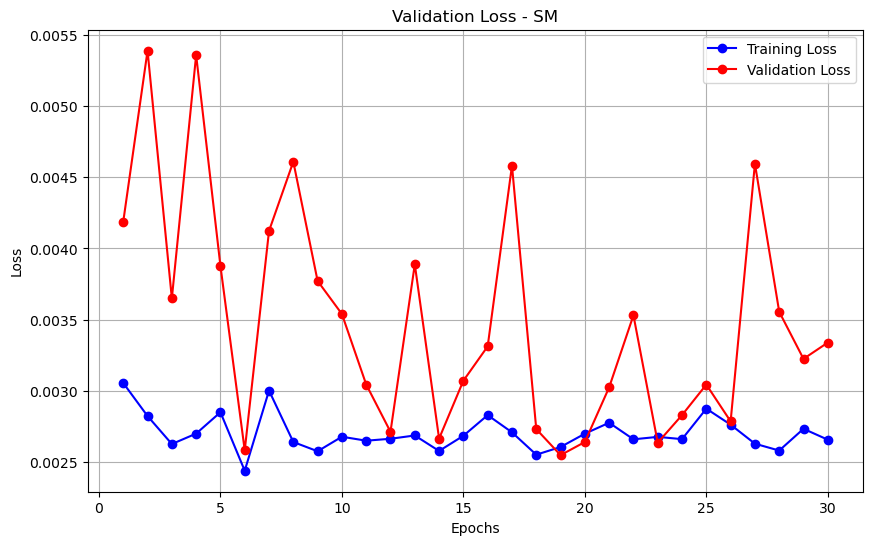

In [88]:
# import matplotlib.pyplot as plt
# Extract the loss values
train_loss = sm_metric_history['train_vwc']
val_loss = sm_metric_history['val_vwc']

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
lepochs = list(range(1,params_train["num_epochs"] + 1))

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
plt.plot(lepochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(lepochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - SM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

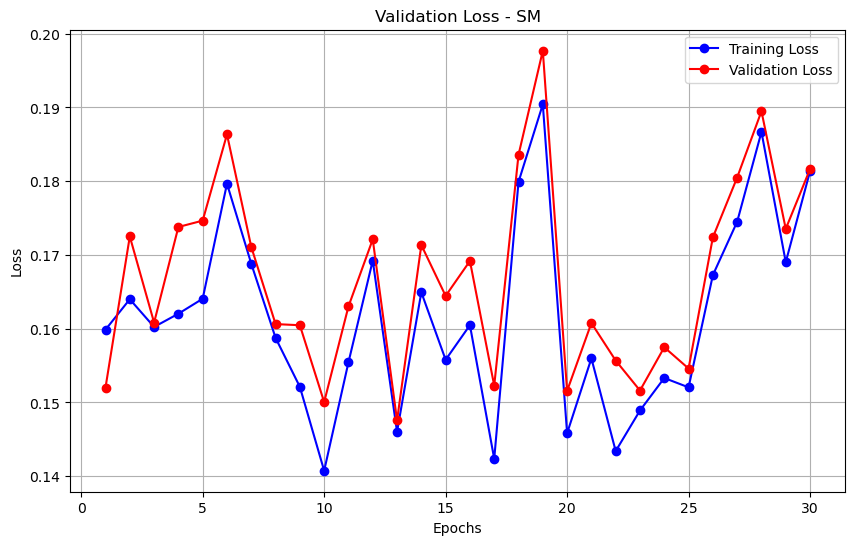

In [89]:
# import matplotlib.pyplot as plt
# Extract the loss values
train_loss = sm_metric_history['train_actevap']
val_loss = sm_metric_history['val_actevap']

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
lepochs = list(range(1,params_train["num_epochs"] + 1))

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
plt.plot(lepochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(lepochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - SM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [35]:
#model.load_state_dict(torch.load(params_train["path2weights"]))

In [36]:
##model= model.to('cuda:0')
#model= model.to('cpu')
#it = iter(train_loader)
# din, static, val = next(it)
# din.shape, static.shape, val.shape
# plt.figure(figsize=(20,10)) 
# plt.plot(model(din, static).detach().cpu().numpy()[101,:,1], label ="model")
# plt.plot(val[101,:,1], label="val")
# plt.legend()

# Inference 

In [ ]:
torch.cuda.empty_cache()

In [115]:
np.isnan(Xd).sum()

tensor(0)

In [123]:
o = model(Xd[:spatial_batch_size,:30], Xs[:spatial_batch_size])

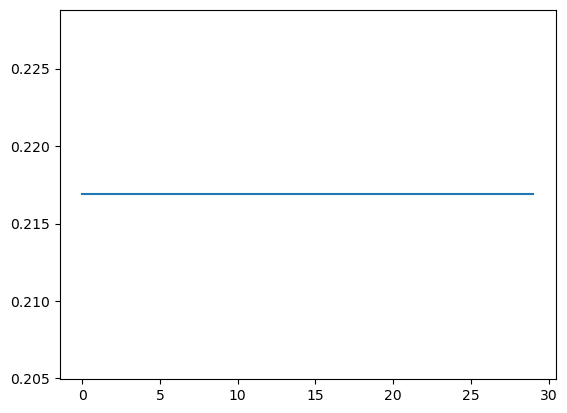

In [124]:
plt.plot(o[19,:,0].detach().numpy())

In [91]:
yhat = predict(Xd, Xs, model, spatial_batch_size, device="cpu")
yhat.shape

(1452, 1827, 2)

In [92]:
lat, lon, time = *forcings.to_dataarray().transpose("lat","lon", "time", "variable").shape[:2], Xd.shape[1]
lat*lon ,time

(1452, 1827)

## SM

In [93]:
y_target, y_pred = prepare_for_plotting(y_target=Y[:,:,[0]], y_pred = yhat[:,:,[0]], shape = (lat, lon, time), coords = targets[target_names].coords)
y_target.shape

(44, 33, 1827)

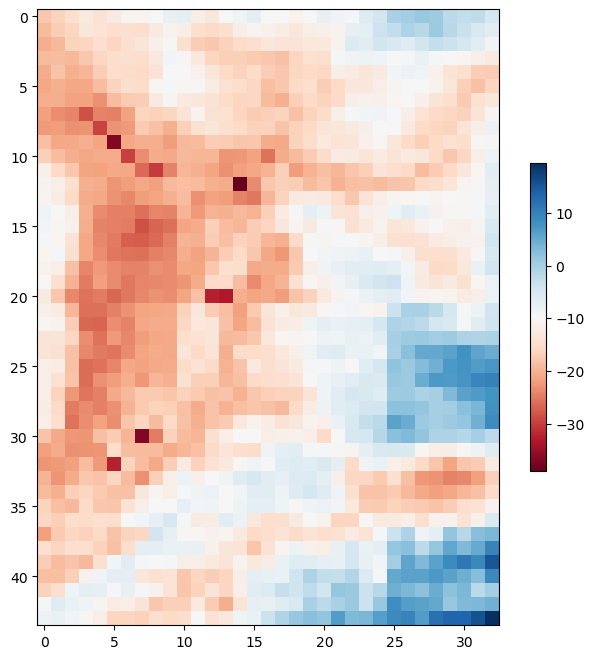

In [94]:
map_pbias(y_target, y_pred, figsize = (8, 8)) #, kwargs_imshow = {"vmin":-100, "vmax":100 })

In [42]:
#map_pearson(y_target, y_pred)

In [95]:
np.unique(y_pred)

array([0.20159571, 0.20442414, 0.20571212, ..., 0.25288576, 0.26116443,
       0.26275885], dtype=float32)

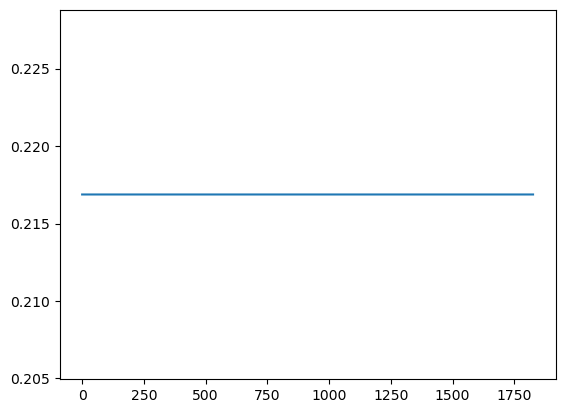

In [98]:
plt.plot(y_pred[16,15])

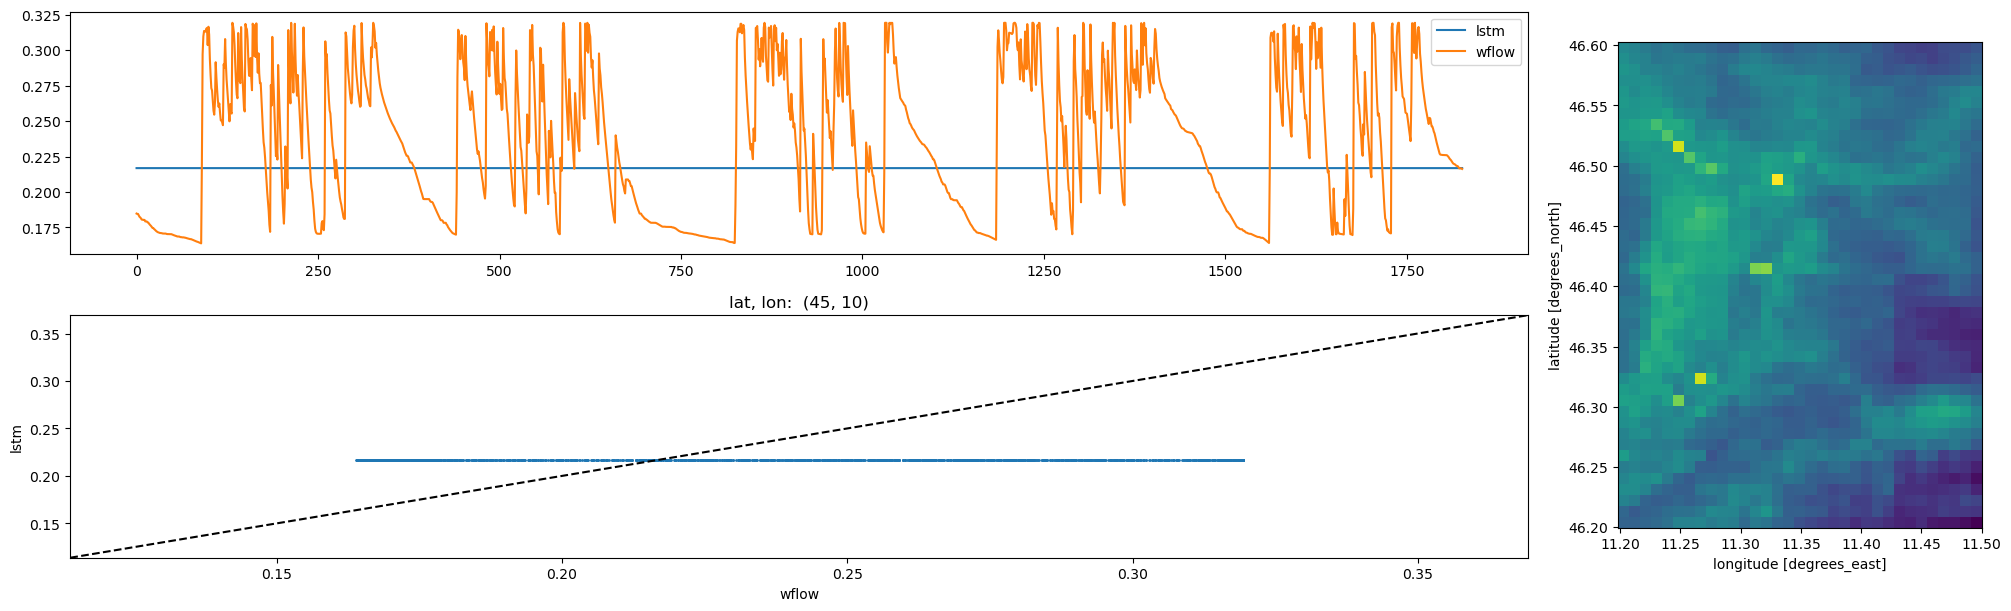

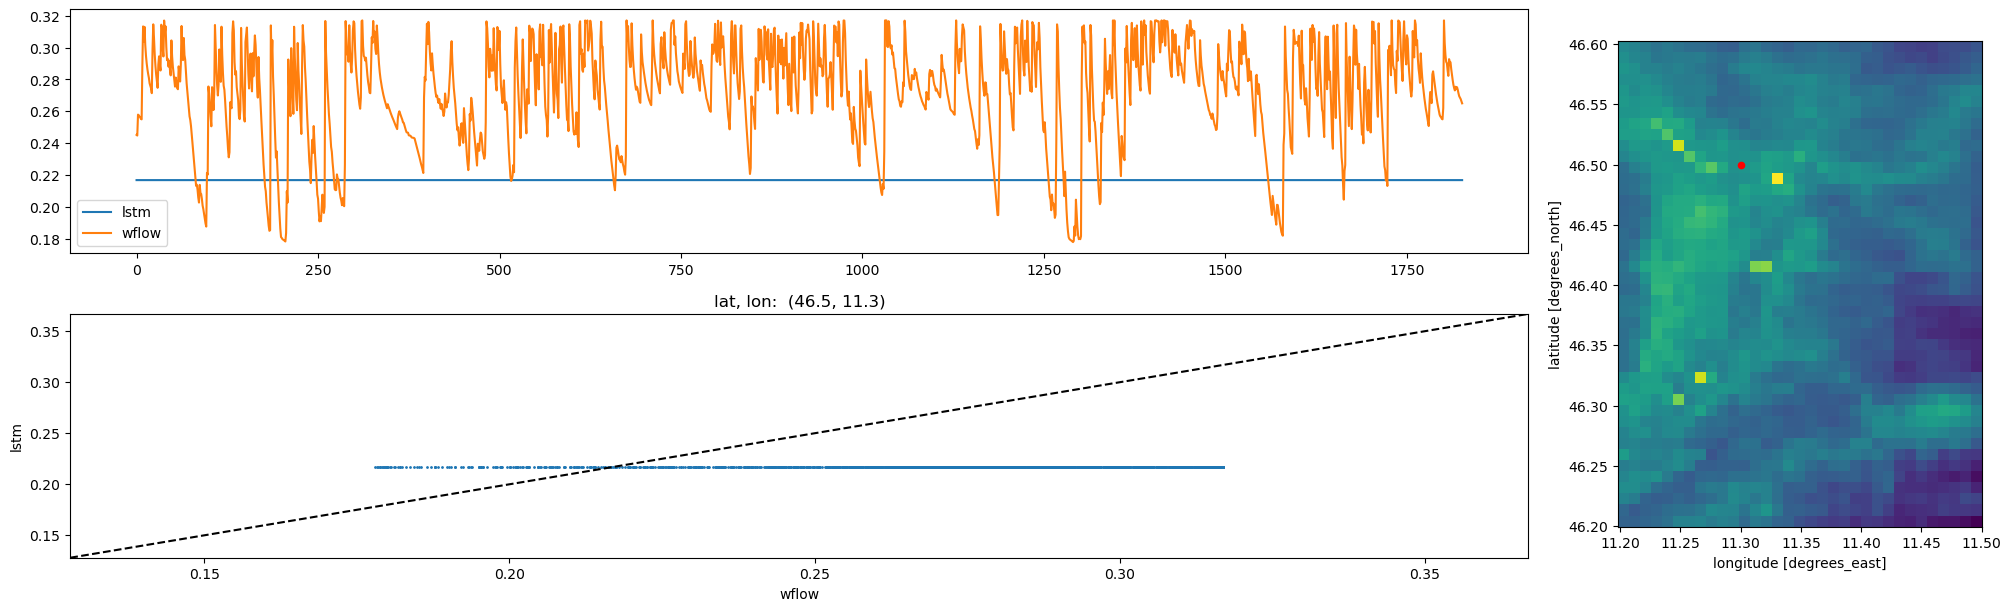

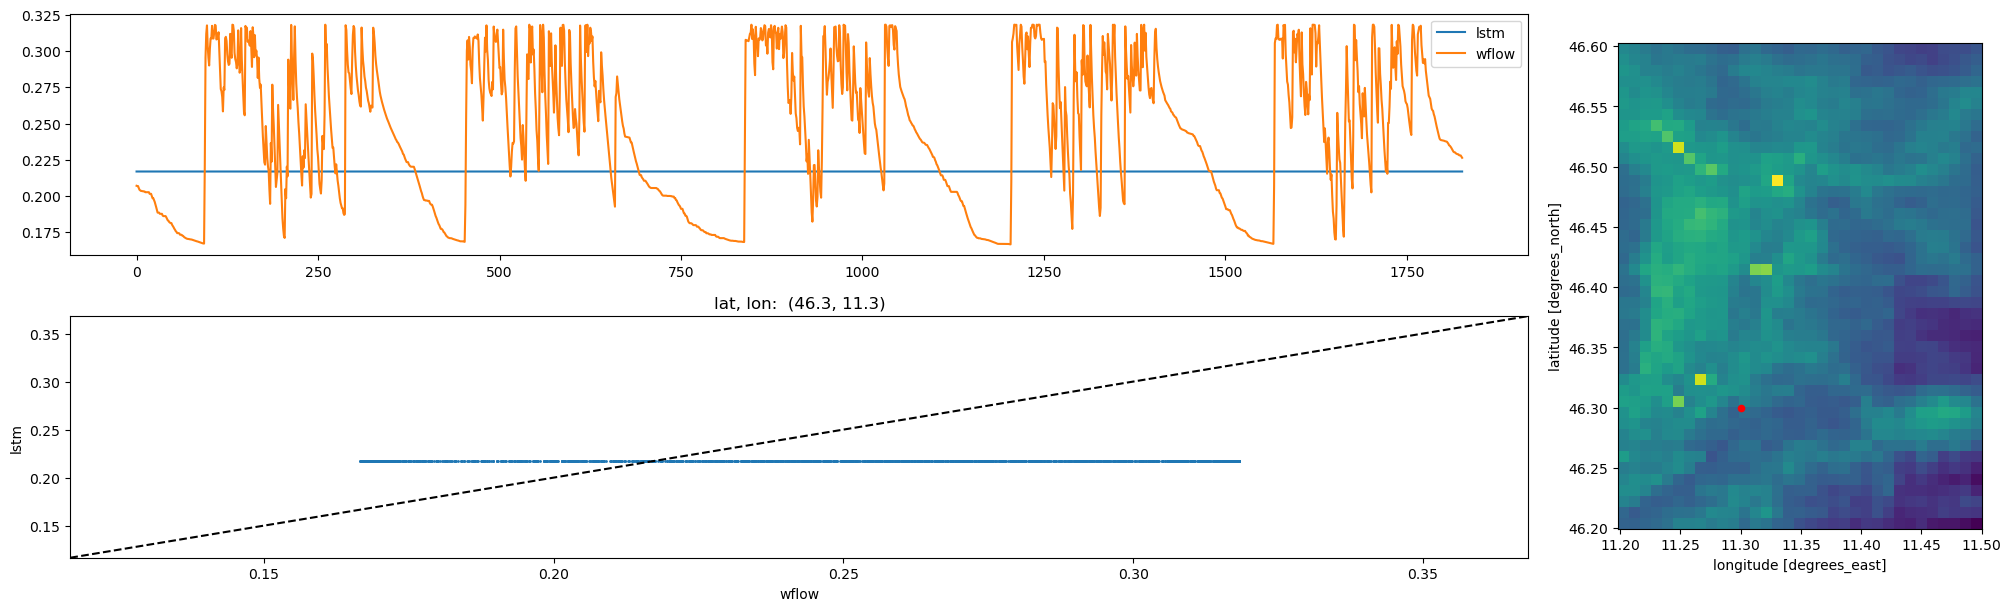

In [44]:
ts_compare(y_target, y_pred, lat = [45, 46.5, 46.3], lon = [10, 11.3, 11.3])

## ET

In [71]:
y_target_et, y_pred_et = prepare_for_plotting(y_target=Y[:,:,[1]], y_pred = yhat[:,:,[1]], shape = (lat, lon, time), coords = targets.coords)
y_target_et.shape

(44, 33, 1827)

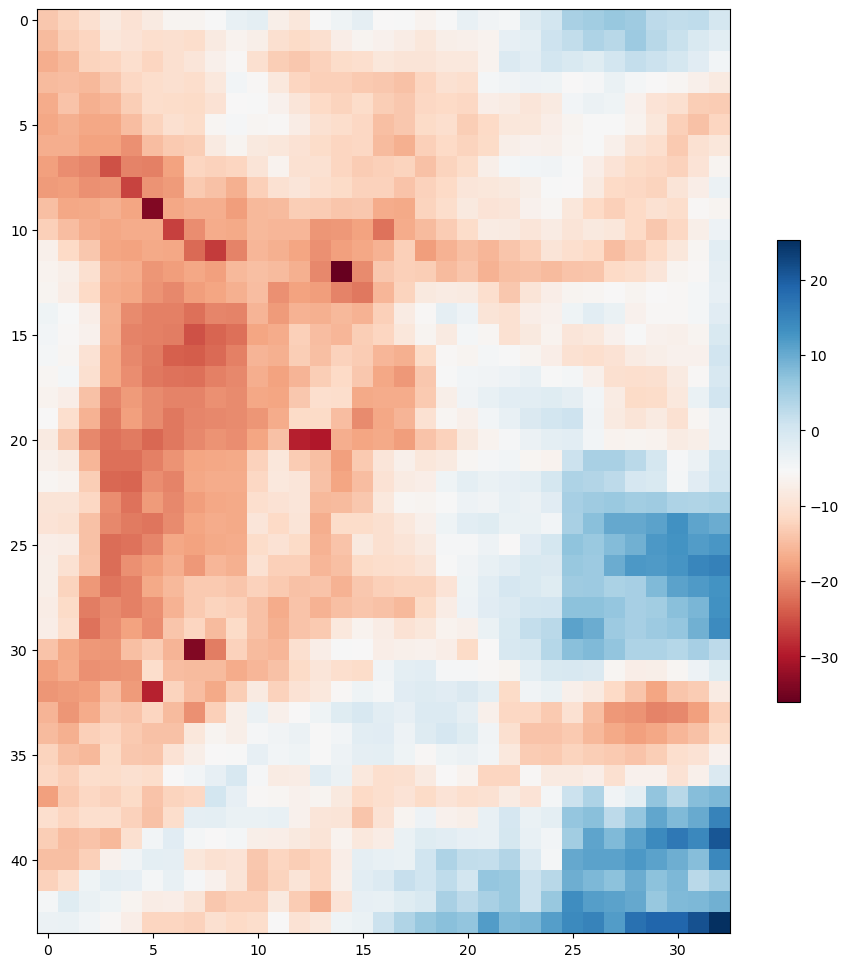

In [72]:
map_pbias(y_target, y_pred, figsize = (12, 12)) #, kwargs_imshow = {"vmin":-100, "vmax":100 })

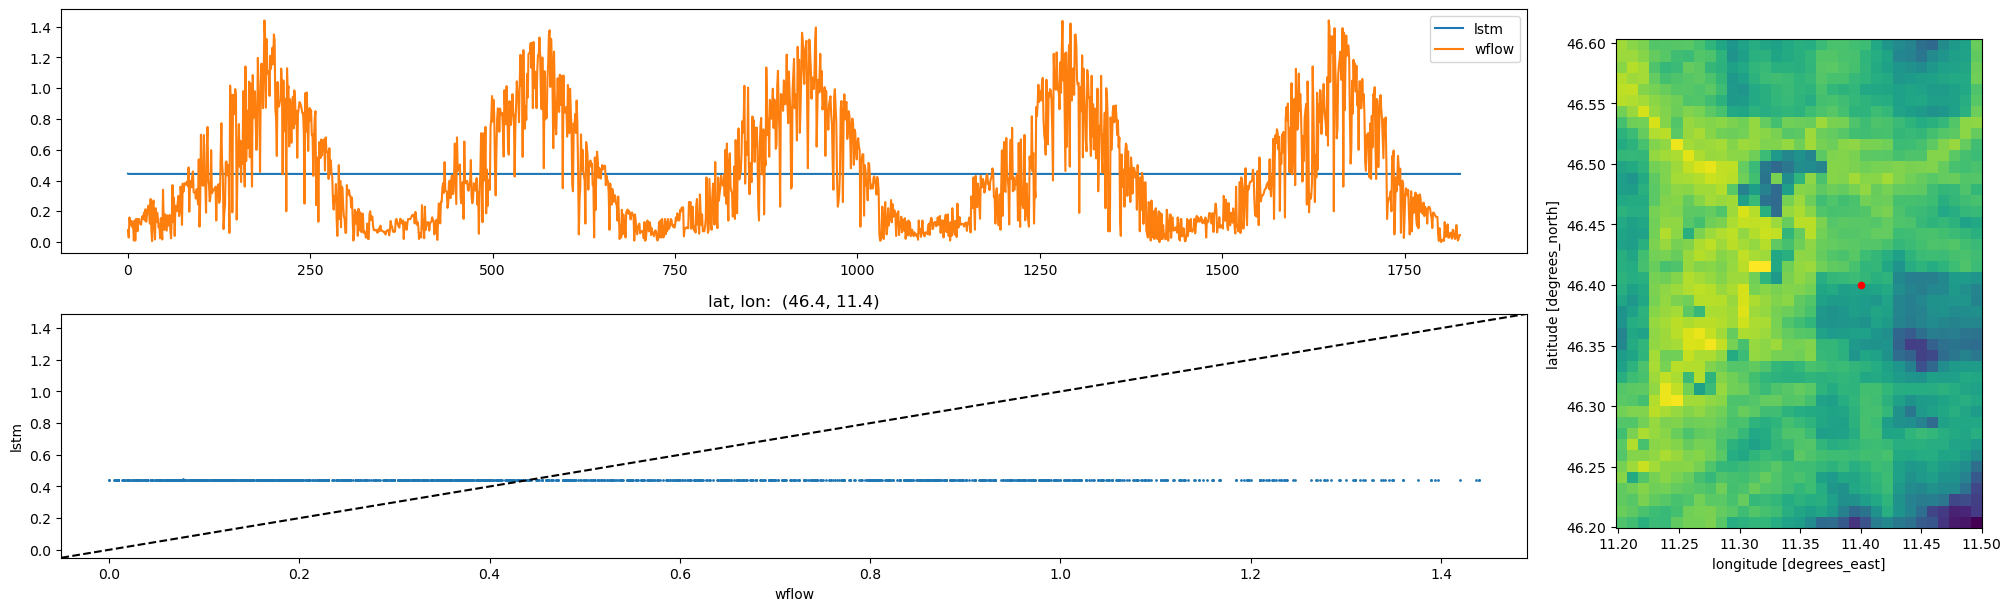

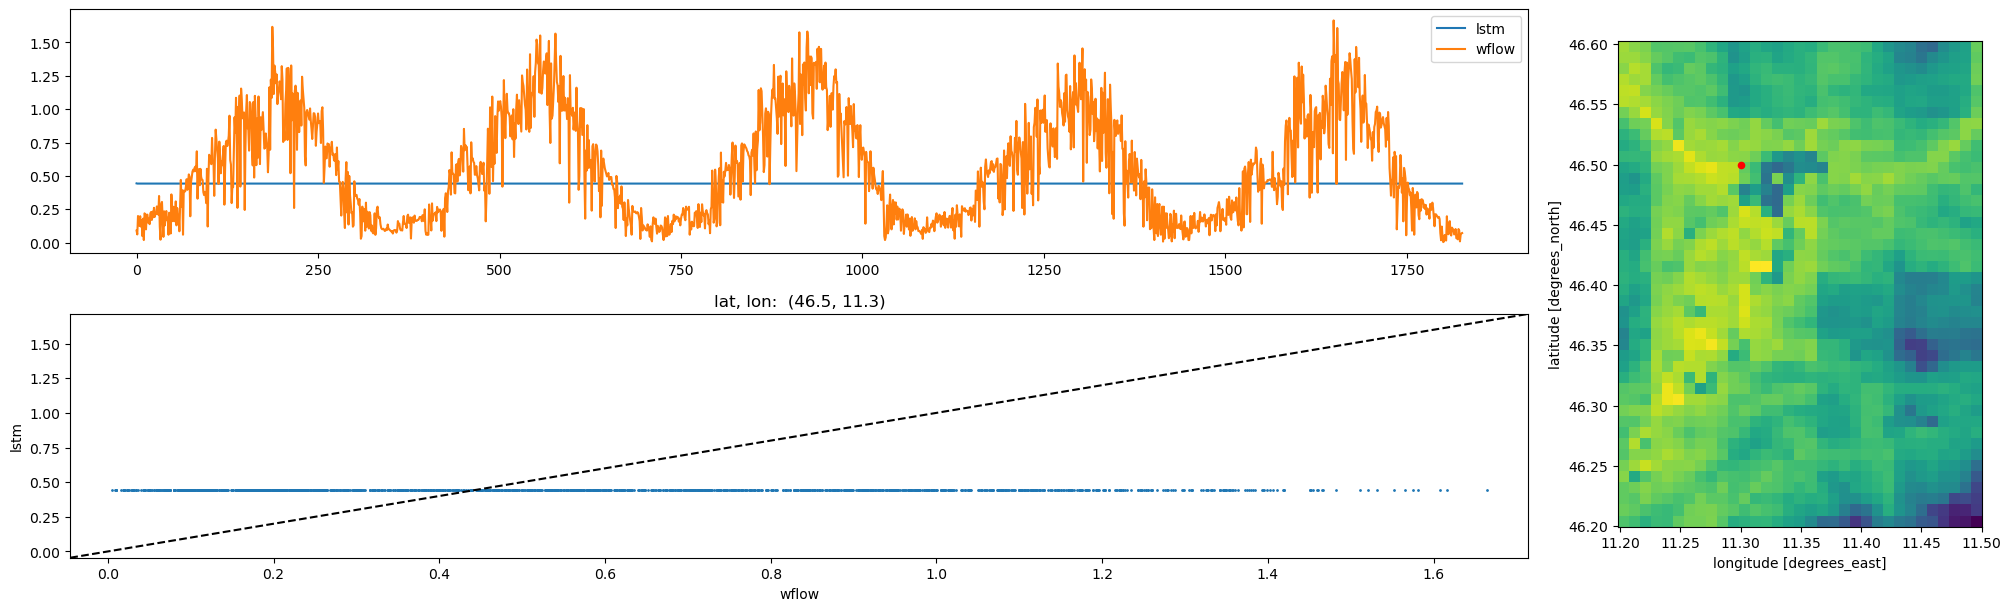

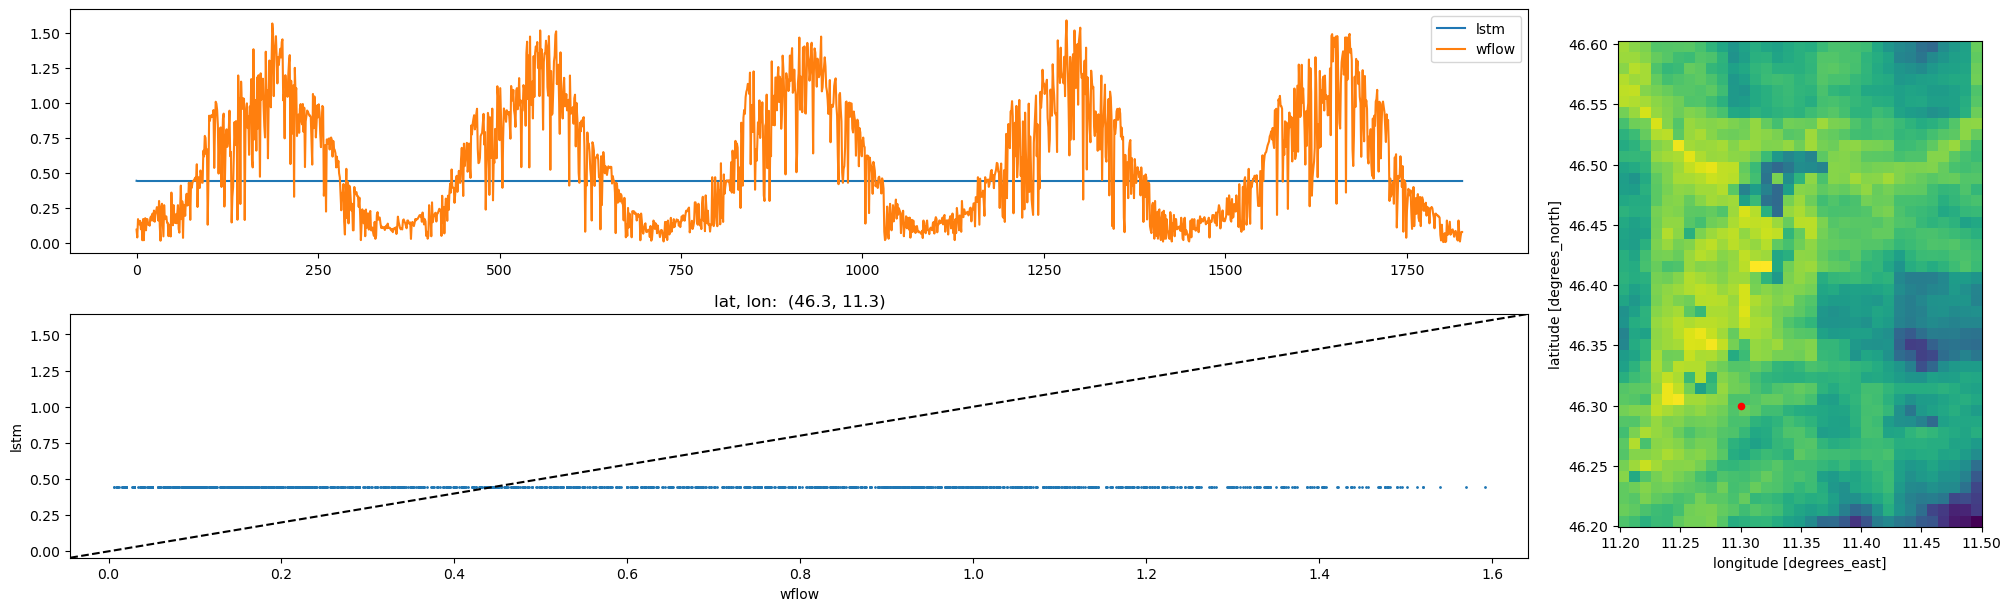

In [73]:
ts_compare(y_target_et, y_pred_et, lat = [46.4, 46.5, 46.3], lon = [11.4, 11.3, 11.3])

In [76]:
np.unique(y_pred_et)

array([0.4427815 , 0.44293824, 0.44315583, 0.44370022, 0.44423062,
       0.4442331 , 0.44423312, 0.4442334 , 0.44446865, 0.44487318,
       0.44507486, 0.44525295, 0.44562593, 0.44581896, 0.4460313 ,
       0.4461423 , 0.4463192 , 0.44642252, 0.4464636 , 0.44651166,
       0.44654882, 0.44659734, 0.4466    , 0.44665006, 0.44666055],
      dtype=float32)